<a href="https://colab.research.google.com/github/igcampos/Mestrado/blob/main/saturacao_implicit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Implicit solution program

Importing the libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from abc import ABC, abstractmethod
import time
import sys
from collections.abc import Iterable
import timeit
from sympy import * 
from scipy.misc import derivative 

##  A simple Newton-Raphson program

In [ ]:
# test program
# implementation of netwon-raphson method
# [J]dX = -r
# nonlinear system:
# (x-4)^2 + (y-4)^2 =5
# x^2 + y^2 = 16


In [ ]:
# defining the residual vectors
def residual_vectors(ab):
  x,y = ab
  return ([(x-4)**2 +(y-4)**2 - 5,
         x**2 + y**2 - 16]
         )


In [ ]:
# defining the jacobian matrix
def jacobin_matrix(ab):
  x,y = ab
  return ([2*(x-4),2*(y-4)],
         [2*x,2*y]
         )


In [ ]:
# defining the Newton-Raphson function
def newton_raphson(fun,jac,x_init,max_ite):
  max_iteration = max_ite
  epsilon = 10**-6

  xnew = x_init
  for k in range(max_iteration):
    J = np.array(jac(xnew))
    r = np.array(fun(xnew))
    delta = np.linalg.solve(J,-r)
    xnew = xnew + delta

    if np.linalg.norm(delta) < epsilon:
      print("The system converges at k={}, and the solution are {}".format(k, xnew))
      break
  else:
    print("The solution does not converge! Try increasing iterations")
  
  return xnew



In [ ]:
# applying the function
init_guess = [1,4]

variable_solution =  newton_raphson(residual_vectors,jacobin_matrix,init_guess,100)

The system converges at k=4, and the solution are [1.805829 3.569171]


### Saturation equations

#### Symbolic derivative calculations

In [ ]:
sw_1 = symbols('sw_1') 
sw_2 = symbols('sw_2')

In [ ]:
alpha0  = 0.1 
mi = 0.3  
swi = 0.2
nw = 2
no = 2
sor = 0.2
aw = (1-swi-sor)**nw 
a0 = (1-swi-sor)**no 
d =  0.85
sw_cc = 0.8
sw_ci = 0.2
# defining the residual vectors
r1 = sw_1 + (alpha0*mi*(sw_1 - swi)**nw)/((mi*(sw_1-swi)**nw)/aw + d*(1-sor-sw_1)/a0)*(1/aw) - (alpha0*mi*(sw_cc - swi)**nw)/((mi*(sw_cc-swi)**nw)/aw + d*(1-sor-sw_cc)/a0)*(1/aw) - sw_ci 
r2 = sw_2 + (alpha0*mi*(sw_2 - swi)**nw)/((mi*(sw_2-swi)**nw)/aw + d*(1-sor-sw_2)/a0)*(1/aw) - (alpha0*mi*(sw_1 - swi)**nw)/((mi*(sw_1-swi)**nw)/aw + d*(1-sor-sw_1)/a0)*(1/aw) - sw_ci


In [ ]:
#defining the derivatives
r1_prime = r1.diff(sw_1)
r2_1_prime = r2.diff(sw_1)
r2_2_prime = r2.diff(sw_2)

In [ ]:
#converting the symbolic varibles to numpy
j11 = lambdify(sw_1, r1_prime, 'numpy')
j21 = lambdify(sw_1, r2_1_prime, 'numpy')
j22 = lambdify(sw_2, r2_2_prime, 'numpy')


In [ ]:
def jacobian_matrix(initial_estimation):
  a,b = initial_estimation
  return ([j11(a), 0],
          [j21(a), j22(b)])
  
def residual_func(initial_estimation):
  a,b = initial_estimation
  return ([r1.subs(sw_1,a),r2.subs([(sw_1,a), (sw_2,b)])])

In [ ]:
# defining the Newton-Raphson function
def newton_raphson(fun,jac,x_init,max_ite):
  max_iteration = max_ite
  epsilon = 10**-10

  xnew = x_init
  for k in range(max_iteration):
    J = np.array(jac(xnew))
    r = np.array(fun(xnew)).astype(np.float64)
    delta = np.linalg.solve(J,-r)
    xnew = xnew + delta
    
    if np.linalg.norm(delta) < epsilon:
      print("The system converges at k={}, and the solution are {}".format(k, xnew))
      break
  else:
    print("The solution does not converge! Try increasing iterations")
  
  return xnew



In [ ]:
# applying the function
init_guess = [0.2,0.2]

variable_solution =  newton_raphson(residual_func,jacobian_matrix,init_guess,100)

The system converges at k=3, and the solution are [0.29930959 0.20069038]


#### Numeric derivative calculations

In [ ]:
# defining the residual equations
# parameter values
alpha0  = 0.1 
mi = 0.3  
swi = 0.2
nw = 2
no = 2
sor = 0.2
aw = (1-swi-sor)**nw 
a0 = (1-swi-sor)**no 
d =  0.85
sw_cc = 0.8
sw_ci = 0.2
# residual equations
def foo(sw_1, sw_2):
  return sw_2 + (alpha0*mi*(sw_2 - swi)**nw)/((mi*(sw_2-swi)**nw)/aw + d*(1-sor-sw_2)/a0)*(1/aw) - (alpha0*mi*(sw_1 - swi)**nw)/((mi*(sw_1-swi)**nw)/aw + d*(1-sor-sw_1)/a0)*(1/aw) - sw_ci

def foo1(sw_1):
  return sw_1 + (alpha0*mi*(sw_1 - swi)**nw)/((mi*(sw_1-swi)**nw)/aw + d*(1-sor-sw_1)/a0)*(1/aw) - (alpha0*mi*(sw_cc - swi)**nw)/((mi*(sw_cc-swi)**nw)/aw + d*(1-sor-sw_cc)/a0)*(1/aw) - sw_ci 


In [ ]:
def partial_derivative(func, var=0, point=[]):
    args = point[:]
    def wraps(sw_1):
        args[var] = sw_1
        return func(*args)
    return derivative(wraps, point[var], dx = 1e-6)

In [ ]:
#defining the derivatives
partial_derivative(foo, 0, point=[3,1])

0.49172707072830946

In [ ]:
def jacobian_matrix(initial_estimation):
  a,b = initial_estimation
  return ([derivative(foo1, a, dx = 1e-6), 0],
          [partial_derivative(foo, 0, point=[a,b]), partial_derivative(foo, 1, point=[a,b])])
  
def residual_func(initial_estimation):
  a,b = initial_estimation
  return ([foo1(a),foo(a,b)])

In [ ]:
# defining the Newton-Raphson function
def newton_raphson(fun,jac,x_init,max_ite):
  max_iteration = max_ite
  epsilon = 10**-6

  xnew = x_init
  for k in range(max_iteration):
    J = np.array(jac(xnew))
    r = np.array(fun(xnew)) #.astype(np.float64)
    delta = np.linalg.solve(J,-r)
    xnew = xnew + delta
    
    if np.linalg.norm(delta) < epsilon:
      print("The system converges at k={}, and the solution are {}".format(k, xnew))
      break
  else:
    print("The solution does not converge! Try increasing iterations")
  
  return xnew



In [ ]:
# applying the function
init_guess = [0.2,0.2]

variable_solution2 =  newton_raphson(residual_func,jacobian_matrix,init_guess,100)

The system converges at k=2, and the solution are [0.29930959 0.20069038]


## Classes 

In [2]:
class Domain:

  def __init__(self, nx, nt, medium):
    """defines domain properties such as grid's number, 
    simulation time and all porous medium properties."""
    self.nx = nx
    self.nt = nt
    self.obj_medium = medium
  
  def vector_domain(self):
    "returns the vector of the domain."
    return np.arange(self.nx)

  def grid_length(self, length_porous):
    """returns the grid length of the domain, in addition stores the porous medium
    length in a new variable."""
    self.length = length_porous
    return length_porous/self.nx

  def grid_dx(self):
    "returns the number of dx from the domain."
    return self.grid_length(self.length)/self.length

  def grid_dt(self, time_step):
    """returns the number of dt from the domain, in addition stores the timestep 
    in a new variable."""
    self.time_step = time_step
    return (time_step*self.obj_medium.ut)/(self.length*self.obj_medium.porosity)

  def courant(self):
    "returns the Courant number"
    return self.grid_dt(self.time_step)/self.grid_dx()


class PorousMedium:

  def __init__(self, porosity, water_viscosity, oil_viscosity, total_velocity):
    """defines the porous medium properties such as porosity, water viscosity, 
    oil viscosity and total velocity of the injected fluid """
    self.porosity = porosity
    self.wvis = water_viscosity
    self.ovis = oil_viscosity
    self.ut = total_velocity
    





In [3]:
class RelativePermeability(ABC):
  """This is an abstract class that defines connate water saturation, residual oil saturation
  and some abstract methods"""
  def __init__(self, swi, sor):
    self.swi = swi
    self.sor = sor

  @abstractmethod
  def water_kr(self):
    pass

  @abstractmethod
  def oil_kr(self):
    pass

  
class CoreyModel(RelativePermeability):
  "This class resolves the relative permeabilities by Corey Model"

  def __init__(self, swi, sor, nw, no, krw_sor, kro_swi):
    """defines some properties such as corey parameters, relative permeabilities of the endpoints,
    and also the properties of the abstract classes."""
    self.nw = nw
    self.no = no
    self.krw_sor = krw_sor
    self.kro_swi = kro_swi
    super().__init__(swi, sor)

  def water_kr(self, sw):
    "function that calculates the relative permeability of water"
    krw = []

    if isinstance(sw, Iterable):

      for i in sw:
          kr = self.krw_sor*((i-self.swi)/(1-self.swi-self.sor))**self.nw
          if kr > self.krw_sor:
            kr = self.krw_sor
          krw.append(kr)
      krw = np.array(krw)

    else:
        kr = self.krw_sor*((sw-self.swi)/(1-self.swi-self.sor))**self.nw
        if kr > self.krw_sor:
          kr = self.krw_sor
        krw.append(kr)
        krw = np.array(krw)
      
    return krw

  def oil_kr(self, sw):
    "function that calculates the relative permeability of oil"
    kro = []

    if isinstance(sw, Iterable):

      for i in sw:
        kr = self.kro_swi*((1-self.sor-i)/(1-self.swi-self.sor))**self.no
        kro.append(kr)
      kro = np.array([self.kro_swi if i >= 1 else i for i in kro]) 
      kro[-1] = 0.0 

    else:
      kr = self.kro_swi*((1-self.sor-sw)/(1-self.swi-self.sor))**self.no
      if kr > self.kro_swi:
        kr = self.kro_swi
      kro.append(kr)
      kro = np.array(kro) 
      
    return kro


In [4]:
class BLModel:

  def __init__(self, sw_ci, sw_cc):
    """This class defines the model that needs to be solved, and in addition stores the 
    initial water saturation and boundary water saturation."""
    self.sw_ci = sw_ci
    self.sw_cc = sw_cc

  
  def transition_time_matrix(self):
    "creates a matrix that represents the time transition of the process."
    injection_time = int(domain.nt/domain.time_step)
    self.injection_time = injection_time
    transition_matrix = np.arange(injection_time)
    self.transition_matrix = transition_matrix
    return transition_matrix
  
  def saturation_matrix(self):
    """creates a matrix that represents the progress of the water saturation 
    in the porous medium in each point grid."""
    saturation_matrix = np.zeros((self.injection_time, domain.nx))
    return saturation_matrix





In [5]:
class FractionalFlow(ABC):
  """This is an abstract class that calculates the fractional flow through two 
  different methods, which are called single point upstream and TVD."""
  def __init__(self):
    self.wvis = medium.wvis
    self.ovis = medium.ovis
    

  @abstractmethod
  def mobility(self):
    pass

class SinglePointUpstream(FractionalFlow):
  """This is a child class that calculates the fractional flow using a single point
  upstream approach."""

  def __init__(self):
    super().__init__()

  def mobility(self, sw):
    "function that calculates the mobility between interblocks."
    numerator = perm.water_kr(sw)/medium.wvis
    denominator = perm.water_kr(sw)/medium.wvis + perm.oil_kr(sw)/medium.ovis
    return numerator/denominator

class TVD(FractionalFlow):
  "This is a child class that calculates the fractional flow using a TVD approach."
    
  def __init__(self):
    super().__init__()

  def mobility(self, sw):
    "function that calculates the mobility between interblocks."
    numerator = perm.water_kr(sw)/medium.wvis
    denominator = perm.water_kr(sw)/medium.wvis + perm.oil_kr(sw)/medium.ovis
    return numerator/denominator

  def limiter_function(self,sw_i,sw_i_plus_one,sw_i_minus_one):
    "function that calculates the limiter function."
    numerator = self.mobility(sw_i) - self.mobility(sw_i_minus_one)
    denominator = self.mobility(sw_i_plus_one) - self.mobility(sw_i)
    if denominator == 0:
      r = 1
      self.r = r
    else:
      r = numerator/denominator
      self.r = r
    return r 

  def van_leer(self):
    "function that calculates the van leer parameter."
    if (1+self.r) == 0:
      fi = 1
      self.fi = fi
    else:
      fi = (self.r+abs(self.r))/(1+self.r)
      self.fi = fi
    return fi

  def flow_adjustment(self, sw_one, sw_two):
    "function that calculates the flow correction."
    flow_adjustment_function = self.fi/2*(self.mobility(sw_one)-self.mobility(sw_two))*(1-domain.courant())
    return flow_adjustment_function


In [70]:
class FiniteDifference(ABC):
  """This is an abstract class that computes the Buckly-Leverett model
  using a finite difference method with an implicit and explicit approach."""

  def __init__(self):
    pass

  @abstractmethod
  def solver(self):
    pass

  def execution_time(self):
    "The purpose of this function is to determine the execution time of the solver."
    return print("The execution time of the solver was {} seconds".format(self.stop - self.start))

  def saturation_curve(self):
    "Function that plots the saturation curves."
    self.matrix = self.obj_saturation
    
    self.matrix = np.insert(self.matrix, 0, values = self.sw_cc, axis=1) 
    length_vector = np.linspace(0, 1, self.obj_domain.nx+1)
    fig = plt.figure(figsize=(8,5))
    ax = plt.subplot(1,1,1)

    #PVI calculations
    td_label_1= self.obj_domain.grid_dt(500)
    td_label_2= self.obj_domain.grid_dt(1000)
    td_label_3= self.obj_domain.grid_dt(3000)
    td_label_4= self.obj_domain.grid_dt(4000)


    ax.plot(length_vector, self.matrix[49], label = "t=360 dias-{} PVI".format(td_label_1))
    ax.plot(length_vector, self.matrix[99], label = "t=730 dias-{} PVI".format(td_label_2))
    ax.plot(length_vector, self.matrix[299], label = "t=1090 dias-{} PVI".format(td_label_3))
    ax.plot(length_vector, self.matrix[399], label = "t=1820 dias-{} PVI".format(td_label_4))

    ax.set_xlabel("x/L", fontsize=15)
    ax.set_ylabel("Saturação da água", fontsize=15)
    plt.title("Curva de Saturação implicita - ut = {} ft³/d".format(self.obj_medium.ut), fontsize=20)
    ax.legend(loc="upper right")
    plt.show()
 

class ExplicitMethod(FiniteDifference):
  "This class gathers all the functionality to compute the Buckley-Leverett model using an explicit approach."

  def __init__(self, fw_approach, saturation, blmodel):
    self.obj_approach = fw_approach
    self.obj_saturation = saturation
    self.obj_blmodel = blmodel
    self.obj_saturation[0,:] = self.obj_blmodel.sw_ci
  

  def saturation_update(self, sw_i_minus_half, sw_i):
    "Function that updates saturations through fractional flow calculations using a Single point upstream approach."
    lambda_i_minus_half = self.obj_approach.mobility(sw_i_minus_half)
    lambda_i = self.obj_approach.mobility(sw_i)
    return dt/dx*(lambda_i_minus_half - lambda_i) + sw_i #requires generalization

  def saturation_update_tvd(self, i, sw_i, sw_i_minus_one, sw_i_plus_one):
    "Function that updates saturations through fractional flow calculations using a TVD approach."
    if i == 0:
      lambda_i_minus_half = self.obj_approach.mobility(sw_i_minus_one)
      
    else:
       lambda_i_minus_half = self.aux
       
    if i == (domain.nx - 1):
      r = self.obj_approach.limiter_function(sw_i,self.obj_blmodel.sw_ci,sw_i_minus_one)
      fi = self.obj_approach.van_leer()
      lambda_i_plus_half = self.obj_approach.mobility(sw_i) + self.obj_approach.flow_adjustment(self.obj_blmodel.sw_ci,sw_i)
    else:
      r = self.obj_approach.limiter_function(sw_i,sw_i_plus_one,sw_i_minus_one)
      fi = self.obj_approach.van_leer()
      lambda_i_plus_half = self.obj_approach.mobility(sw_i) + self.obj_approach.flow_adjustment(sw_i_plus_one,sw_i)

    self.aux = lambda_i_plus_half #test later with indentation 

    return dt/dx*(lambda_i_minus_half - lambda_i_plus_half) + sw_i #requires generalization


  def solver(self):
    "Function that explicitly solves the model."

    if isinstance(self.obj_approach, SinglePointUpstream) == True:
      t1 = timeit.default_timer()
      self.start = t1
      #algorithm to calculate the Buckley-Leverett model using Single Point Upstream approach
      
      for n in self.obj_blmodel.transition_time_matrix():
        #first row calculation
        if n == 0:
          for i in domain.vector_domain(): #need of improvement 
            if i == 0:
              #first grid point
              self.obj_saturation[n,i] = self.saturation_update(self.obj_blmodel.sw_cc, self.obj_blmodel.sw_ci)
            else:
              #other points
              self.obj_saturation[n,i] = self.saturation_update(self.obj_blmodel.sw_ci, self.obj_blmodel.sw_ci)
        else:
          for i in domain.vector_domain():
            if i == 0:
              #first grid point
              self.obj_saturation[n,i] = self.saturation_update(self.obj_blmodel.sw_cc, self.obj_saturation[n-1,i])
            else:
              #other points
              self.obj_saturation[n,i] = self.saturation_update(self.obj_saturation[n-1,i-1], self.obj_saturation[n-1,i])            

      t2 = timeit.default_timer()
      self.stop = t2

    else:
      t1 = timeit.default_timer()
      self.start = t1
      #the algorithm to calculate the Buckley-Leverett model using TVD approach

      for n in self.obj_blmodel.transition_time_matrix():
        #first row calculation
        if n == 0:
          for i in domain.vector_domain(): #need of improvement 
            if i == 0:
              # first grid point
              self.obj_saturation[n,i] = self.saturation_update_tvd(i, self.obj_blmodel.sw_ci, self.obj_blmodel.sw_cc, self.obj_blmodel.sw_ci)
            else:
              #other points
              self.obj_saturation[n,i] = self.saturation_update_tvd(i, self.obj_blmodel.sw_ci, self.obj_blmodel.sw_ci, self.obj_blmodel.sw_ci)
        else:
          for i in domain.vector_domain():
            if i == 0:
              # first grid point
              self.obj_saturation[n,i] = self.saturation_update_tvd(i, self.obj_saturation[n-1,i], self.obj_blmodel.sw_cc, self.obj_saturation[n-1,i+1])
            else:
              #other points
              if i == domain.nx-1:
                self.obj_saturation[n,i] = self.saturation_update_tvd(i, self.obj_saturation[n-1,i], self.obj_saturation[n-1,i-1], self.obj_blmodel.sw_ci)
              else:
                self.obj_saturation[n,i] = self.saturation_update_tvd(i, self.obj_saturation[n-1,i], self.obj_saturation[n-1,i-1], self.obj_saturation[n-1,i+1])
      
      matrix = self.obj_saturation
      t2 = timeit.default_timer()
      self.stop = t2
      return matrix            

  
class ImplicitMethod(FiniteDifference):
  "This class gathers all the functionality to compute the Buckley-Leverett model using an implicit approach."

  def __init__(self, domain, perm, fw_approach, saturation, blmodel):
    #objects
    self.obj_approach = fw_approach
    self.obj_saturation = saturation
    self.obj_blmodel = blmodel
    self.obj_domain = domain
    self.obj_perm = perm
    self.obj_medium = medium
    
    #properties 
    self.A = self.obj_domain.courant()*self.obj_perm.krw_sor
    self.B = self.obj_perm.krw_sor
    self.C = ((1-self.obj_perm.swi)**self.obj_perm.nw)/((1-self.obj_perm.swi)**self.obj_perm.no)*self.obj_perm.kro_swi
    self.sw_cc = self.obj_blmodel.sw_cc
    self.sw_ci = self.obj_blmodel.sw_ci
    
    
  def symbolic_varibles(self):
    "Function that transforms the variables into a symbolic form."
    symbols_dictionary = {}

    for i in range(1,self.obj_domain.nx+1):
      symbols_dictionary[f'sw_{i}'] = symbols(f'sw_{i}')
    return symbols_dictionary

  def residual_function(self, sw_i, sw_i_minus_one=0.2, sw_n=0.2):
    "Private function that creates the residual equations in a generic form."

    #self.dicti = self.symbolic_varibles()
    
    return sw_i + [(self.A*(sw_i - self.obj_perm.swi)**self.obj_perm.nw)/((self.B*(sw_i-self.obj_perm.swi)**self.obj_perm.nw) + self.C*((1-self.obj_perm.sor-sw_i)**self.obj_perm.no))] - [(self.A*(sw_i_minus_one - self.obj_perm.swi)**self.obj_perm.nw)/((self.B*(sw_i_minus_one-self.obj_perm.swi)**self.obj_perm.nw) + self.C*((1-self.obj_perm.sor-sw_i_minus_one)**self.obj_perm.no))] - sw_n

  def get_keys(self, dicti):
    return list(dicti.keys())

  def residual_matrix(self, n, estimation):
    "It creates a matrix with the residual equations at a specific point, which is used by the Newton-Raphson method."
    zero_matrix = np.zeros(self.obj_domain.nx)
    #keys_list = self.get_keys(self.dicti)

    for i in range(self.obj_domain.nx-1):
      if i == 0:
        zero_matrix[i] = self.residual_function(self.dicti[f'sw_{i+1}'], self.sw_cc, self.obj_saturation[n,i])
        zero_matrix[i] = zero_matrix[i].subs(self.dicti[f'sw_{i+1}'], estimation[i])
      else:
        zero_matrix[i] = self.residual_function(self.dicti[f'sw_{i+1}'], self.dicti[f'sw_{i}'], self.obj_saturation[n,i])
        zero_matrix[i] = zero_matrix[i].subs([(self.dicti[f'sw_{i+1}'], estimation[i+1]),(self.dicti[f'sw_{i}'], estimation[i])])
    return zero_matrix

  def new_residual_matrix(self, n, estimation):
      "It creates a matrix with the residual equations at a specific point, which is used by the Newton-Raphson method."
      zero_matrix = np.zeros(self.obj_domain.nx)

      for i in range(self.domain.nx-1):
        if i == 0:
          zero_matrix[i] = self.residual_function(self.obj_saturation[n,i], self.obj_blmodel.sw_cc, self.obj_saturation[n,i])
        else:
          zero_matrix[i] = self.residual_function(self.obj_saturation[n,i], self.obj_saturation[n,i-1], self.obj_saturation[n,i])
      return zero_matrix


  def residual_function_matrix(self):
    "It creates a matrix with the residual equations in symbolic form."
    
    # Important: The derivative of the saturation at the previous timestep is zero, therefore, it is not important to determine its value!
    # Hence, it assumes that n is equal to zero.   
    
    resid_matrix = np.zeros(self.obj_domain.nx)  
    for i in range(self.obj_domain.nx-1):
      if i == 0:
        resid_matrix[i] = self.residual_function(self.dicti[f'sw_{i+1}'], self.sw_cc, self.obj_saturation[0,i]) 
      else:
        resid_matrix[i] = self.residual_function(self.dicti[f'sw_{i+1}'], self.dicti[f'sw_{i}'], self.obj_saturation[0,i])
    return resid_matrix    

  def jacobian_derivative(self, resid, i, j):
    "Calculate the derivative of the equations."
    resid = residual_function_matrix()
    return resid[i].diff(self.dicti[f'sw_{j}'])


  def jacobian_matrix(self, estimation):
    "Private function that creates the jacobian matrix, which is used by the Newton-Raphson method."
    zero_jacobian_matrix = np.zeros((self.obj_saturation.shape[1],self.obj_saturation.shape[1]))
    resid = residual_function_matrix()
    
    for i in range(self.obj_domain.nx-1):
      for j in range(self.obj_domain.nx-1):
        if (i == j) and (i == 0):
          # first point
          aux = lambdify(self.dicti[f'sw_{i+1}'], self.jacobian_derivative(self.resid,i,j+1), 'numpy') 
          zero_jacobian_matrix[i,j] = aux(estimation[j])
        elif (i == j):
          # this point is replaced by a current saturation point
          aux = lambdify(self.dicti[f'sw_{i+1}'], self.jacobian_derivative(self.resid,i,j+1), 'numpy') 
          zero_jacobian_matrix[i,j] = aux(estimation[j]) 
        elif (i == j+1):
          # this point is replaced by a previous saturation point
          aux = lambdify(self.dicti[f'sw_{i}'], self.jacobian_derivative(self.resid,i,j+1), 'numpy') 
          zero_jacobian_matrix[i,j] = aux(estimation[j])  
        else:
          pass

    return zero_jacobian_matrix

  def partial_derivative(self, func, var=0, point=[]):
    "Function that computes the partial derivatives."
    args = point[:]
    def wraps(self, sw_i):
        args[var] = sw_i
        return func(*args)
    return derivative(self.wraps, point[var], dx = 1e-6)

  def new_jacobian_matrix(self, estimation):
    "Private function that creates the jacobian matrix using numerical derivations, which is used by the Newton-Raphson method."
    zero_jacobian_matrix = np.zeros((self.obj_saturation.shape[1],self.obj_saturation.shape[1]))
      
    for i in range(self.domain.nx-1):
      for j in range(self.domain.nx-1):
        if (i == j) and (i == 0):
          # first point
          zero_jacobian_matrix[i,j] = derivative(self.residual_function, estimation[j], dx = 1e-6)
        elif (i == j):
          # this point is replaced by a current saturation point
          zero_jacobian_matrix[i,j] = self.partial_derivative(self.residual_function, 0, point = [estimation[j],estimation[j-1],estimation[j]])
        elif (i == j+1):
          # this point is replaced by a previous saturation point
          zero_jacobian_matrix[i,j] = self.partial_derivative(self.residual_function, 1, point = [estimation[j],estimation[j-1],estimation[j]]) 
        else:
          pass

    return zero_jacobian_matrix

  def newton_raphson(self, n, x_init, max_ite=1000, tol=10**-10):
    "Function that applies the Newton-Raphson method to implicitly calculate the nonlinear system of equations"
    self.max_iteration = max_ite
    self.epsilon = tol

    xnew = x_init
    for k in range(self.max_iteration):
      J = self.jacobian_matrix(xnew)
      r = self.residual_matrix(n, xnew).astype(np.float64)
      delta = np.linalg.solve(J,-r)
      xnew = xnew + delta

      if np.linalg.norm(delta) < self.epsilon:
        #print("The system converges at k={}, and the solution are {}".format(k, xnew))
        break
      else:
        print("The solution does not converge! Try increasing the iterations.")
    
    return xnew

  def num_newton_raphson(self, n, x_init, max_ite=1000, tol=10**-6):
      "Function that applies the Newton-Raphson method to implicitly calculate the nonlinear system of equations"
      self.max_iteration = max_ite
      self.epsilon = tol

      xnew = x_init
      for k in range(self.max_iteration):
        J = self.new_jacobian_matrix(xnew)
        r = self.new_residual_matrix(n, xnew)
        delta = np.linalg.solve(J,-r)
        xnew = xnew + delta

        if np.linalg.norm(delta) < self.epsilon:
          #print("The system converges at k={}, and the solution are {}".format(k, xnew))
          break
        else:
          print("The solution does not converge! Try increasing the iterations.")
      
      return xnew
  
  def newton_raphson2(self, n, i, x_init, max_ite=1000, tol=10**-6):
      "Function that applies the Newton-Raphson method to implicitly calculate the nonlinear system of equations"

      x,b = x_init
      for k in range(max_ite):
        xnew = x - self.residual_function(x, b, self.obj_saturation[n,i])/derivative(self.residual_function, x, dx = 1e-6)
        
        if abs(xnew-x) < tol:
          #print("The system converges at k={}, and the solution are {}".format(k, xnew))
          break
        elif k == max_ite-1:
          print("The solution does not converge! Try increasing the iterations.")
          break
        else:
          x = xnew
          
      return xnew

  def solver(self):
    "Function that implicitly solves the model."
    t1 = timeit.default_timer()
    self.start = t1

    for n in self.obj_blmodel.transition_time_matrix()-1:
      x_init = self.obj_saturation[n] 
      aux = self.newton_raphson(n, x_init)
      self.obj_saturation[n+1] = aux

    t2 = timeit.default_timer()
    self.stop = t2
    
    return obj_saturation

  def solver2(self):
    "Function that implicitly solves the model using a point-point approach."
    t1 = timeit.default_timer()
    self.start = t1
    
    for n in self.obj_blmodel.transition_time_matrix():
      if n == 0:
        self.obj_saturation[0,:] = self.sw_ci
      else:
        x_init = self.obj_saturation[n-1]
        for i in range(self.obj_domain.nx):
          if i == 0:
            x_init_2 = np.array([x_init[i], self.obj_blmodel.sw_cc])
            self.obj_saturation[n,i] = self.newton_raphson2(n-1, i, x_init_2)
            x_aux = self.obj_saturation[n,i]
          else:
            x_init_2 = np.array([x_init[i], x_aux])
            self.obj_saturation[n,i] = self.newton_raphson2(n-1, i, x_init_2)
            x_aux = self.obj_saturation[n,i]
         
    matrix = self.obj_saturation
    t2 = timeit.default_timer()
    self.stop = t2
    
    return matrix 



#### Debbuging

In [ ]:
  def symbolic_varibles():
    "Function that transforms the variables into a symbolic form."
    symbols_dictionary = {}

    for i in range(1,domain.nx+1):
      symbols_dictionary[f'sw_{i}'] = symbols(f'sw_{i}')

    #locals().update(symbols_dictionary)
    return symbols_dictionary
  
  def residual_function(sw_i, sw_i_minus_one, sw_n):
    "Private function that creates the residual equations in a generic form."
    alpha0  = domain.courant()
    mi = medium.ovis/medium.wvis*perm.krw_sor
    swi = perm.swi
    sor = perm.sor
    nw = perm.nw
    no = perm.no
    aw = (1-swi-sor)**nw 
    a0 = (1-swi-sor)**no 
    d =  perm.kro_swi
    sw_cc = blmodel.sw_cc
    sw_ci = blmodel.sw_ci

    dicti = symbolic_varibles()
    
    return sw_i + (alpha0*mi*(sw_i - swi)**nw)/((mi*(sw_i-swi)**nw)/aw + d*(1-sor-sw_i)/a0)*(1/aw) - (alpha0*mi*(sw_i_minus_one - swi)**nw)/((mi*(sw_i_minus_one-swi)**nw)/aw + d*(1-sor-sw_i_minus_one)/a0)*(1/aw) - sw_n



def residual_matrix(n, estimation):
    "It creates a matrix with the residual equations at a specific point, which is used by the Newton-Raphson method."
    zero_matrix = np.zeros(domain.nx)


    for i in range(domain.nx-1):
      if i == 0:
        zero_matrix[i] = residual_function(dicti[f'sw_{i+1}'], blmodel.sw_cc, saturation[n,i]).subs(dicti[f'sw_{i+1}'], estimation[i])
        
      #elif i == self.obj_domain.nx-1:
        #zero_matrix[i] = self.residual_function(self.dicti[f'sw_{i+1}'], self.dicti[f'sw_{i}'], self.obj_saturation[n,i])
        #zero_matrix[i] = zero_matrix[i].subs(self.dicti[f'sw_{i+1}'], estimation[i+1])
      else:
        zero_matrix[i] = residual_function(dicti[f'sw_{i+1}'], dicti[f'sw_{i}'], saturation[n,i]).subs([(dicti[f'sw_{i+1}'], estimation[i+1]),(dicti[f'sw_{i}'], estimation[i])])
        #zero_matrix[i] = zero_matrix[i].subs([(dicti[f'sw_{i+1}'], estimation[i+1]),(dicti[f'sw_{i}'], estimation[i])])
    return zero_matrix

In [ ]:
dicti = symbolic_varibles()

In [ ]:
saturation[0,:] = blmodel.sw_ci

In [ ]:
teste = residual_matrix(0, saturation[0])

In [ ]:
teste

array([-0.1,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
        0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
        0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
        0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
        0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
        0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
        0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
        0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
        0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
        0. ])

In [ ]:
  def residual_function_matrix():
    "It creates a matrix with the residual equations in symbolic form."
    
    # Important: The derivative of the saturation at the previous timestep is zero, therefore, it is not important to determine its value!
    # Hence, it assumes that n is equal to zero.   
    
    #resid_matrix = np.zeros(domain.nx)
    resid_matrix = []  
    for i in range(domain.nx-1):
      if i == 0:
        resid_matrix.append(residual_function(dicti[f'sw_{i+1}'], blmodel.sw_cc, saturation[0,i])) 
      else:
        resid_matrix.append(residual_function(dicti[f'sw_{i+1}'], dicti[f'sw_{i}'], saturation[0,i]))
    return np.array(resid_matrix)    

  def jacobian_derivative(resid, i, j):
    "Calculate the derivative of the equations."
    resid = residual_function_matrix()
    return resid[i].diff(dicti[f'sw_{j}'])


  def jacobian_matrix(estimation):
    "Private function that creates the jacobian matrix, which is used by the Newton-Raphson method."
    zero_jacobian_matrix = np.zeros((saturation.shape[1],saturation.shape[1]))
    resid = residual_function_matrix()
    
    for i in range(domain.nx-1):
      for j in range(domain.nx-1):
        if (i == j) and (i == 0):
          # first point
          aux = lambdify(dicti[f'sw_{i+1}'], jacobian_derivative(resid,i,j+1), 'numpy') 
          zero_jacobian_matrix[i,j] = aux(estimation[j])
        elif (i == j):
          # this point is replaced by a current saturation point
          aux = lambdify(dicti[f'sw_{i+1}'], jacobian_derivative(resid,i,j+1), 'numpy') 
          zero_jacobian_matrix[i,j] = aux(estimation[j]) 
        elif (i == j+1):
          # this point is replaced by a previous saturation point
          aux = lambdify(dicti[f'sw_{i}'], jacobian_derivative(resid,i,j+1), 'numpy') 
          zero_jacobian_matrix[i,j] = aux(estimation[j])  
        else:
          pass

    return zero_jacobian_matrix

In [ ]:
teste2 = residual_function_matrix()

In [ ]:
teste3 = jacobian_derivative(teste2,0,1)

In [ ]:
teste4 = jacobian_matrix(saturation[0])

In [ ]:
teste4[60]

In [ ]:
 def newton_raphson(n, x_init, max_ite=1000, tol=10**-10):
    "Function that applies the Newton-Raphson method to implicitly calculate the nonlinear system of equations"
    max_iteration = max_ite
    epsilon = tol

    xnew = x_init
    for k in range(max_iteration):
      J = jacobian_matrix(xnew)
      r = residual_matrix(n, xnew)#.astype(np.float64)
      delta = np.linalg.solve(J,-r)
      xnew = xnew + delta

      if np.linalg.norm(delta) < epsilon:
        #print("The system converges at k={}, and the solution are {}".format(k, xnew))
        break
      else:
        print("The solution does not converge! Try increasing the iterations.")
    
    return xnew

In [ ]:
teste5 = newton_raphson(0, saturation[0])

LinAlgError: ignored

## Algorithm

In [57]:
#Creating the porous medium
medium = PorousMedium(0.2, 1, 1, 0.1)
#Creating the domain
domain = Domain(100,4000, medium)

In [58]:
#vector domain
domain.vector_domain()
#grid length
grid = domain.grid_length(5000)
#grid dx
dx = domain.grid_dx()
#grid dt
dt = domain.grid_dt(10)
#Courant
Cu = domain.courant()

In [59]:
#Creating the object that represents the relative permeability
perm = CoreyModel(0.2, 0.2, 2, 2, 0.3, 0.85)

In [60]:
#Creating the object that represents the Buckley-Leverett model
blmodel = BLModel(0.2,0.8)

In [61]:
#Creating transition time matrix
blmodel.transition_time_matrix()

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [62]:
#Creating saturation matrix
saturation = blmodel.saturation_matrix()
saturation.shape

(400, 100)

In [63]:
#Choosing the fractional flow calculation approach
tvd = TVD()
spu = SinglePointUpstream()

In [ ]:
#Creating the object that represents the chosen approach - SPU
finitedifference = ExplicitMethod(spu, saturation, blmodel)

In [ ]:
#Calculation of saturation matrix
finitedifference.solver()

In [ ]:
finitedifference.execution_time()

The solver execution time was 1.9576063719996455 seconds


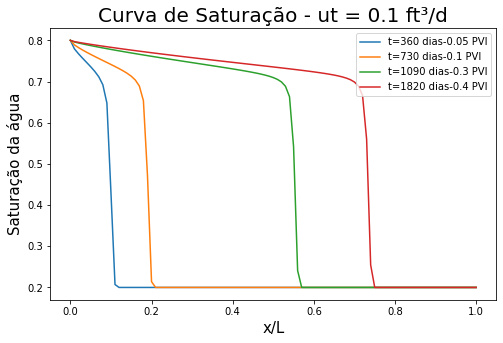

In [ ]:
#plotting the saturation curves
finitedifference.saturation_curve()

In [ ]:
#Creating the object that represents the chosen approach - TVD
finitedifference = ExplicitMethod(tvd, saturation, blmodel)

In [ ]:
#Calculation of saturation matrix
finitedifference.solver()

In [ ]:
finitedifference.execution_time()

The solver execution time was 6.480860445997678 seconds


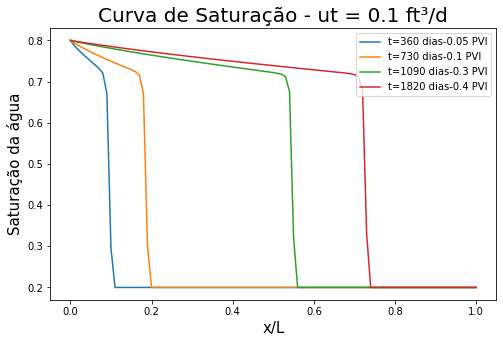

In [ ]:
#plotting the saturation curves
finitedifference.saturation_curve()

In [64]:
#Creating the object that implicitly calculates the BL model with a spu approach
finitedifference2 = ImplicitMethod(domain, perm, spu, saturation, blmodel)

In [65]:
#Calculation of the saturation matrix
finitedifference2.solver2()

array([[0.2       , 0.2       , 0.2       , ..., 0.2       , 0.2       ,
        0.2       ],
       [0.29865185, 0.20134797, 0.20000018, ..., 0.2       , 0.2       ,
        0.2       ],
       [0.39145812, 0.20853435, 0.20000753, ..., 0.2       , 0.2       ,
        0.2       ],
       ...,
       [0.79689094, 0.79500711, 0.79327926, ..., 0.2       , 0.2       ,
        0.2       ],
       [0.79689859, 0.79501931, 0.79329558, ..., 0.2       , 0.2       ,
        0.2       ],
       [0.7969062 , 0.79503145, 0.79331182, ..., 0.2       , 0.2       ,
        0.2       ]])

In [67]:
finitedifference2.execution_time()

The execution time of the solver was 10.33839934900061 seconds


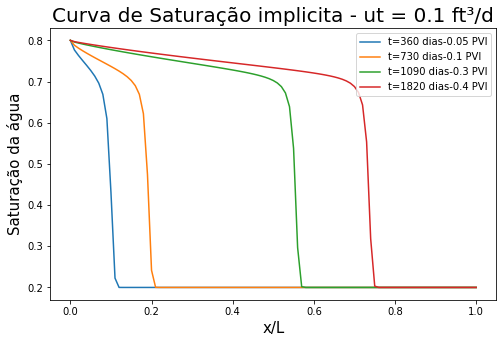

In [69]:
finitedifference2.saturation_curve()

## Alternative Implicit Method

In [49]:
def residual_function(sw_i, sw_i_minus_one=0.2, sw_n=0.2):
    "Private function that creates the residual equations in a generic form."
    alpha0  = domain.courant()
    mi = medium.ovis/medium.wvis*perm.krw_sor
    swi = perm.swi
    sor = perm.sor
    nw = perm.nw
    no = perm.no
    aw = (1-swi-sor)**nw 
    a0 = (1-swi-sor)**no 
    d =  perm.kro_swi
    sw_cc = blmodel.sw_cc
    sw_ci = blmodel.sw_ci
    
    return sw_i + (alpha0*mi*(sw_i - swi)**nw)/((mi*(sw_i-swi)**nw)/aw + d*(1-sor-sw_i)/a0)*(1/aw) - (alpha0*mi*(sw_i_minus_one - swi)**nw)/((mi*(sw_i_minus_one-swi)**nw)/aw + d*(1-sor-sw_i_minus_one)/a0)*(1/aw) - sw_n


def new_residual_matrix(n, estimation):
    "It creates a matrix with the residual equations at a specific point, which is used by the Newton-Raphson method."
    zero_matrix = np.zeros(domain.nx)

    for i in range(domain.nx-1):
      if i == 0:
        zero_matrix[i] = residual_function(saturation[n,i], blmodel.sw_cc, saturation[n,i])
      else:
        zero_matrix[i] = residual_function(saturation[n,i], saturation[n,i-1], saturation[n,i])
    return zero_matrix

In [ ]:
saturation[0,:] = blmodel.sw_ci
teste5 = residual_matrix(0, saturation[0])

In [ ]:
 def partial_derivative(func, var=0, point=[]):
    args = point[:]
    def wraps(sw_i):
        args[var] = sw_i
        return func(*args)
    return derivative(wraps, point[var], dx = 1e-6)

def new_jacobian_matrix(estimation):
  "Private function that creates the jacobian matrix, which is used by the Newton-Raphson method."
  zero_jacobian_matrix = np.zeros((saturation.shape[1],saturation.shape[1]))
    
  for i in range(domain.nx-1):
    for j in range(domain.nx-1):
      if (i == j) and (i == 0):
        # first point
        zero_jacobian_matrix[i,j] = derivative(residual_function, estimation[j], dx = 1e-6)
      elif (i == j):
        # this point is replaced by a current saturation point
        zero_jacobian_matrix[i,j] = partial_derivative(residual_function, 0, point = [estimation[j],estimation[j-1],estimation[j]])
      elif (i == j+1):
        # this point is replaced by a previous saturation point
        zero_jacobian_matrix[i,j] = partial_derivative(residual_function, 1, point = [estimation[j],estimation[j-1],estimation[j]]) 
      else:
        pass

  return zero_jacobian_matrix

In [ ]:
teste6 = jacobian_matrix(saturation[0])

In [ ]:
teste6

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
def newton_raphson(n, x_init, max_ite=1000, tol=10**-6):
    "Function that applies the Newton-Raphson method to implicitly calculate the nonlinear system of equations"
    max_iteration = max_ite
    epsilon = tol

    xnew = x_init
    for k in range(max_iteration):
      J = jacobian_matrix(xnew)
      r = new_residual_matrix(n, xnew)
      delta = np.linalg.solve(J,-r)
      xnew = xnew + delta

      if np.linalg.norm(delta) < epsilon:
        #print("The system converges at k={}, and the solution are {}".format(k, xnew))
        break
      else:
        print("The solution does not converge! Try increasing the iterations.")
    
    return xnew

In [ ]:
teste7 = newton_raphson(0, saturation[0])

In [ ]:
det = np.linalg.det(teste6)
print(det)

0.0


In [47]:
#one root newton-raphson method

def newton_raphson1(n, i, x_init, max_ite=1000, tol=10**-6):
    "Function that applies the Newton-Raphson method to implicitly calculate the nonlinear system of equations"
    max_iteration = max_ite
    epsilon = tol

    x,b = x_init
    for k in range(max_iteration):
      xnew = x - residual_function(x, b, saturation[n,i])/derivative(residual_function, x, dx = 1e-6)
      
      if abs(xnew-x) < epsilon:
        #print("The system converges at k={}, and the solution are {}".format(k, xnew))
        break
      elif k == max_ite-1:
        print("The solution does not converge! Try increasing the iterations.")
        break
      else:
        x = xnew
         
    return xnew

In [ ]:
xini = np.array([0.2, 0.8])
teste8 = newton_raphson1(0, 0, xini)

The system converges at k=2, and the solution are 0.2993095907007573


In [ ]:
teste9 = newton_raphson1(0, 1, [0.2,teste8])

The system converges at k=1, and the solution are 0.20069038123011573


In [ ]:
teste10 = newton_raphson1(0, 2, [0.2,teste9])

The system converges at k=0, and the solution are 0.20000002806912728


In [51]:
def solver():
    "Function that implicitly solves the model."
    t1 = timeit.default_timer()
    start = t1
    
    for n in blmodel.transition_time_matrix():
      if n == 0:
        saturation[0,:] = blmodel.sw_ci
      else: 
        x_init = saturation[n-1]
        for i in range(domain.nx):
          if i == 0:
            x_init_2 = np.array([x_init[i], blmodel.sw_cc])
            saturation[n,i] = newton_raphson1(n-1, i, x_init_2)
            x_aux = saturation[n,i]
          else:
            x_init_2 = np.array([x_init[i], x_aux])
            saturation[n,i] = newton_raphson1(n-1, i, x_init_2)
            x_aux = saturation[n,i]
         

    t2 = timeit.default_timer()
    stop = t2
    
    return saturation  

In [52]:
#saturation[0,:] = blmodel.sw_ci
teste11 = solver()

In [53]:
teste11.shape

(400, 100)

In [54]:
  def saturation_curve(teste11):
    "Function that plots the saturation curves."
    matrix = teste11
    
    matrix = np.insert(matrix, 0, values = blmodel.sw_cc, axis=1) 
    length_vector = np.linspace(0, 1, domain.nx+1)
    fig = plt.figure(figsize=(8,5))
    ax = plt.subplot(1,1,1)

    #PVI calculations
    td_label_1= domain.grid_dt(500)
    td_label_2= domain.grid_dt(1000)
    td_label_3= domain.grid_dt(3000)
    td_label_4= domain.grid_dt(4000)


    ax.plot(length_vector, matrix[49], label = "t=360 dias-{} PVI".format(td_label_1))
    ax.plot(length_vector, matrix[99], label = "t=730 dias-{} PVI".format(td_label_2))
    ax.plot(length_vector, matrix[299], label = "t=1090 dias-{} PVI".format(td_label_3))
    ax.plot(length_vector, matrix[399], label = "t=1820 dias-{} PVI".format(td_label_4))

    ax.set_xlabel("x/L", fontsize=15)
    ax.set_ylabel("Saturação da água", fontsize=15)
    plt.title("Curva de Saturação implicita - ut = {} ft³/d".format(medium.ut), fontsize=20)
    ax.legend(loc="upper right")
    plt.show()

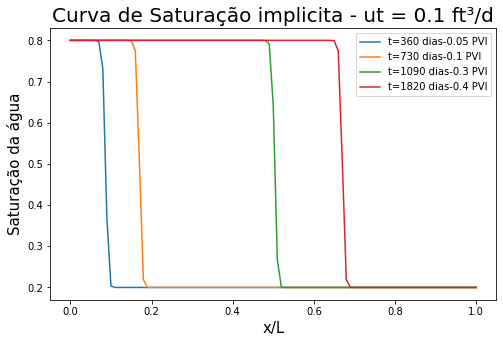

In [55]:
saturation_curve(teste11)

In [24]:
teste20 = []
for n in blmodel.transition_time_matrix():
  teste20.append(n)


In [28]:
saturation[0].shape

(100,)

In [43]:
teste21 = []
for i in saturation[0]:
  teste21.append(i)


In [44]:
len(teste21)

100